## Introduction
After having trained a model on the AWS GPU instance, it is time to see how it is performing. I will begin with simple visualizing of the spec files and target/predicted bboxes, but this can only take us so far in understanding model performance. So, I will be applying the Intersection over Union (IoU) metric to understand the model performance on the test set. 

In [1]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
import json
from typing import List, Union

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou, nms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics

from modeling import CRES_Dataset, CRES_DM, CRES_LM
root_dir = sys.path[0]+'/config/fasterRCNN'

#### Loading saved model

In [2]:
PATH = 'tb_logs/cres/version_{}/checkpoints/epoch={:02d}.ckpt'.format(56, 96)
cres_lm = CRES_LM.load_from_checkpoint(PATH)

In [3]:
# Define training object, max_pool=16, file_max=1000, batch_size=1 correspond to 
# the conditions for the model 56 inside of tb_logs
cres_dm = CRES_DM(root_dir,
                  max_pool=16,
                  file_max=1000,
                  batch_size=1,
                  num_workers=4
                  )

#### Generate some predictions

In [7]:
test_dataiter = iter(cres_dm.test_dataloader())
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)
preds

[{'boxes': tensor([[146.5394, 160.3418, 319.6300, 167.0255],
          [171.9239, 118.2621, 319.6597, 124.9091],
          [204.2013, 144.0251, 319.3449, 146.0231],
          [ 55.0153, 249.9287, 248.4135, 252.0918],
          [297.8691, 189.0088, 319.7892, 190.0078]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1]),
  'scores': tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9995], grad_fn=<IndexBackward0>)}]

## Visualize

In [10]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds

def show(imgs, figsize=(10.0, 10.0)):
    """Displays a single image or list of images. Taken more or less from
    the pytorch docs:
    https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-a-grid-of-images

    Args:
        imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
            of shape (3, H, W) or a single image of shape (3, H, W).
        figsize (Tuple[float, float]): size of figure to display.

    Returns:
        None
    """

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=figsize, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

    return None

def display_boxes(imgs, target_pred_dict, class_map, width = 1, fill=False):
    """
    Takes a list of images and a list of target or prediction dictionaries
    of the same len and overlays bounding boxes onto the images.
    Returns:
        result_imgs (List[torch.ByteTensor[3, H, W]]): list of images with
            overlaid bounding boxes.
    """
    num_imgs = len(imgs)
    result_imgs = [
        draw_bounding_boxes(
            imgs[i].type(torch.uint8),
            target_pred_dict[i]["boxes"].int(),
            fill=fill,
            colors=[
                class_map[j.item()]["target_color"]
                for j in target_pred_dict[i]["labels"]
            ],
            width=width,
        )
        for i in range(num_imgs)
    ]

    return result_imgs

In [15]:
%matplotlib widget
@interact
def vizualize_targets_predictions(
                                target_box = widgets.Checkbox(value=False,description='target boxes'),
                                pred_box = widgets.Checkbox(value=False,description='prediction boxes'),
                                num_imgs= widgets.IntSlider(value=len(preds),min=0,max=len(preds),step=1, description = "num_imgs"),
                                score_thresh = widgets.FloatSlider(value=.5,min=0,max=1,step=.0001, description = "score_thresh"),
                                width =  widgets.IntSlider(value=1,min=1,max=10,step=1), 
                                display_size = widgets.IntSlider(value=10,min=2,max=50,step=1)
                                ): 
    preds_cut = apply_score_cut(preds, score_threshold=score_thresh)
    result_image = [imgs[i] for i in range(num_imgs)]

    if target_box: 
        result_image = display_boxes(result_image, targets, cres_dm.class_map, fill = True)

    if pred_box: 
        result_image = display_boxes(result_image, preds_cut, cres_dm.class_map)

    grid = make_grid(result_image)
    show(grid, figsize = (display_size, display_size))

interactive(children=(Checkbox(value=False, description='target boxes'), Checkbox(value=False, description='pr…

#### Rerun this cell in order to generate new image above.

In [16]:
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)

## Model Performance with IoU
IoU is a valuable metric for object detection. It is the ratio of the intersection area of the target and prediction boundary box to the union area of the boxes, so a value of 1 is perfect overlap and 0 is no overlap. The tricky part here is that the predictions are ordered by their score in the model, not by the order in which the targets were originally given. For now, I am aiming to get a lower bound on the model performance. This will be done by taking the IoU of all pairs of boxes in an image (between targets and predictions - the default behavior of `box_iou`) and keeping scores greater than 0. The average of this will include the IoU of boxes that just happen to overlap to some degree, hence it being a lower bound. However, it will allow for a better understanding of model performance.

In [17]:
keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=.1)
print(preds[0]['boxes'][keep], preds[0]['scores'][keep])
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])

tensor([[104.8611, 207.9345, 316.4753, 213.1320],
        [ 53.6938, 130.9858, 319.6172, 139.2126],
        [ 47.5200, 150.9538, 320.0000, 155.9877],
        [175.3214, 161.9942, 319.7940, 165.9533],
        [186.1987, 101.4301, 319.8575, 106.9352]], grad_fn=<IndexBackward0>) tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9997], grad_fn=<IndexBackward0>) tensor([1, 1, 1, 1, 1])


tensor([[0.]])

In [18]:
targets[0]['boxes'],preds[0]['boxes'][keep]

(tensor([[ 49, 151, 320, 156],
         [105, 208, 320, 213],
         [188, 101, 320, 107],
         [159, 163, 320, 165],
         [ 52, 131, 320, 139],
         [175, 162, 320, 166],
         [146, 103, 320, 104]], dtype=torch.int32),
 tensor([[104.8611, 207.9345, 316.4753, 213.1320],
         [ 53.6938, 130.9858, 319.6172, 139.2126],
         [ 47.5200, 150.9538, 320.0000, 155.9877],
         [175.3214, 161.9942, 319.7940, 165.9533],
         [186.1987, 101.4301, 319.8575, 106.9352]], grad_fn=<IndexBackward0>))

In [19]:
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])

tensor([[0.0000, 0.0000, 0.9831, 0.0000, 0.0000],
        [0.9462, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9052],
        [0.0000, 0.0000, 0.0000, 0.4776, 0.0000],
        [0.0000, 0.9651, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9833, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1722]], grad_fn=<DivBackward0>)

In [20]:
targets[0], apply_score_cut(preds)[0]

({'boxes': tensor([[ 49, 151, 320, 156],
          [105, 208, 320, 213],
          [188, 101, 320, 107],
          [159, 163, 320, 165],
          [ 52, 131, 320, 139],
          [175, 162, 320, 166],
          [146, 103, 320, 104]], dtype=torch.int32),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1])},
 {'boxes': tensor([[104.8611, 207.9345, 316.4753, 213.1320],
          [ 53.6938, 130.9858, 319.6172, 139.2126],
          [ 47.5200, 150.9538, 320.0000, 155.9877],
          [175.3214, 161.9942, 319.7940, 165.9533],
          [186.1987, 101.4301, 319.8575, 106.9352],
          [147.3757, 102.9199, 317.2120, 103.8246],
          [158.7767, 102.5128, 317.3881, 104.7494]], grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9997, 0.9934, 0.6637],
         grad_fn=<IndexBackward0>)})

In [21]:
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])[box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0]

tensor([0.9831, 0.9462, 0.9052, 0.4776, 0.9651, 0.9833, 0.1722],
       grad_fn=<IndexBackward0>)

#### Defining function to explore relationship of IoU threshold on application of NMS to the predictions. Want to see if there is an ideal value which will give same number of predictions as targets

In [25]:
def get_ious(iou_threshold):
    '''
    Function for getting all of the IoU values for a predicted bbox in a given image.
    '''
    ious = []
    pred_targ_len = []
    test_dataiter = iter(cres_dm.test_dataloader())
    iterating = True
    i=0
    while iterating:
        try:
            # Update user that function is running
            if not i%25:
                print(f'On image {i}')
            # get image and target from test dataloader
            imgs, targets = test_dataiter.next()
            
            # generate prediction from model
            preds = cres_lm(imgs)
            
            # Apply NMS with given threshold
            keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=iou_threshold)
            
            # Store the IoU for each prediction box that passes NMS
            ious += box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])\
            [box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0].tolist()
            
            # Also store if the number of predictions for the image match the number of targets
            pred_targ_len.append(len(preds[0]['boxes'][keep]) == len(targets[0]['boxes']))
            
            # Increment sanity counter since this takes a while to run
            i+=1
        # eventually the iteration fails, so capture that here 
        except:
            # Just to guarantee that we exit the loop...
            iterating = False
            # Return IoU values and info on number of preds/targets
            return ious, pred_targ_len
        
def plot_ious(ious, thresholds):
    '''
    Function for plotting the output of the IoU function above
    '''
    for i, it in enumerate(thresholds):
        iou_temp = torch.detach(torch.tensor(ious[i][0])).numpy()
        plt.figure(figsize=(10,10))
        plt.scatter(list(range(len(iou_temp))), iou_temp, marker='.')
        plt.hlines(y=iou_temp.mean(),xmin=0, xmax=len(iou_temp), color='red', label=f'mean={iou_temp.mean().round(3):.3f}')
        plt.ylabel('IoU')
        plt.title(f'IoU for each prediction, NMS threshold = {it},\
     fraction with correct number of predictions={sum(ious[i][1])/len(ious[i][1]) :.3f}')
        plt.legend()
        plt.show()
    return None

In [7]:
iou_thresholds = [.1, .3, .5]
iou_info = [get_ious(it) for it in iou_thresholds]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


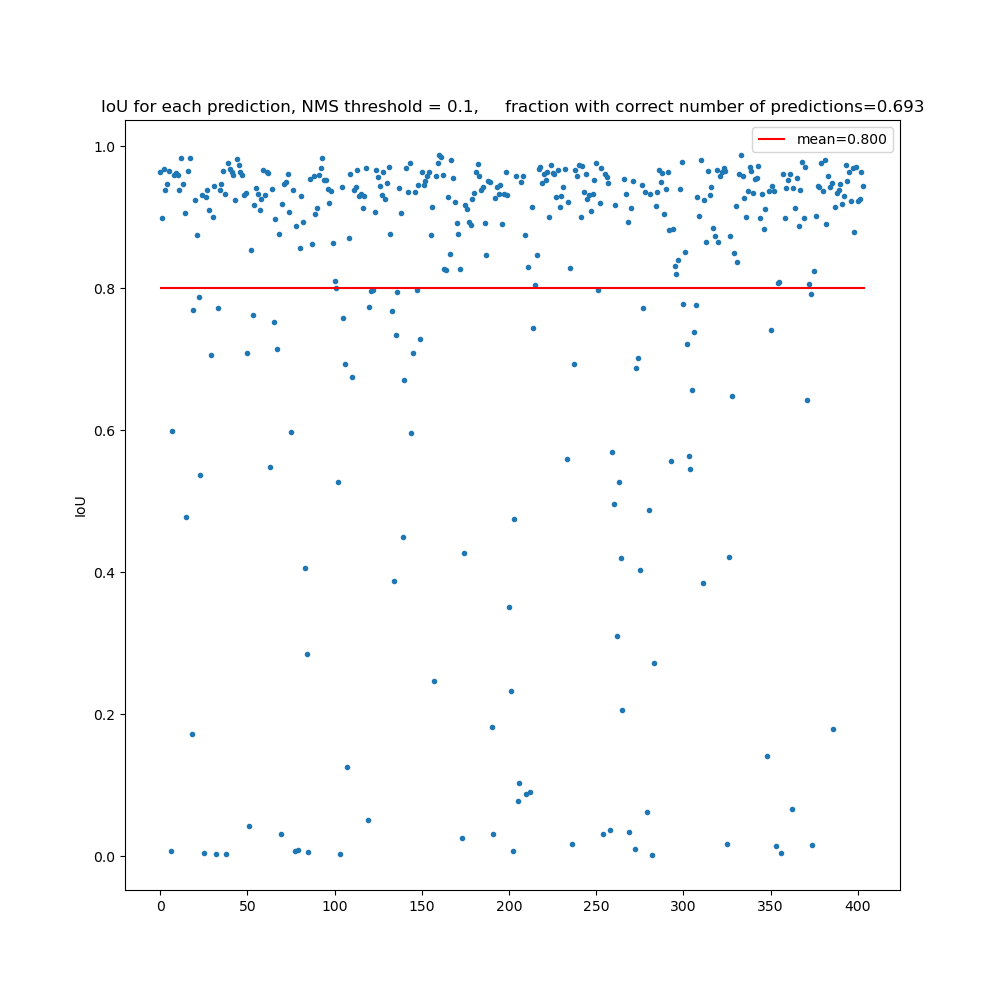

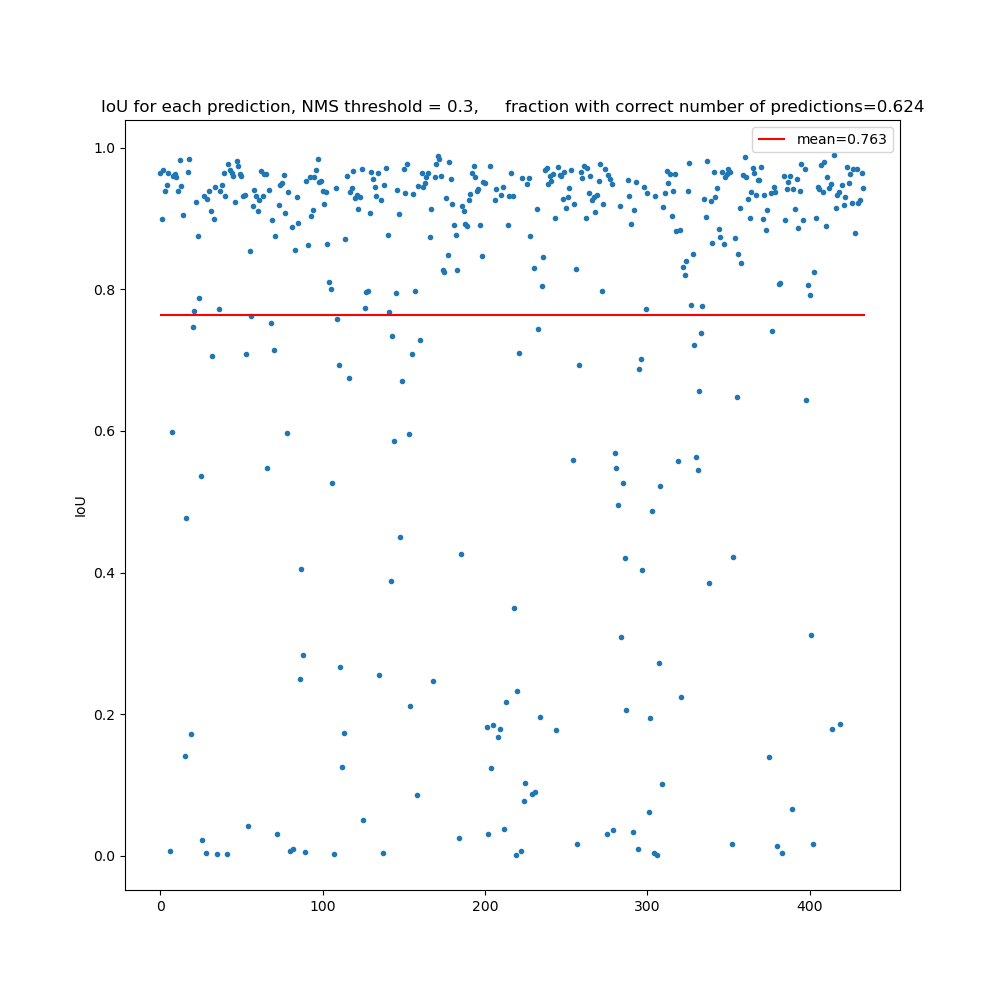

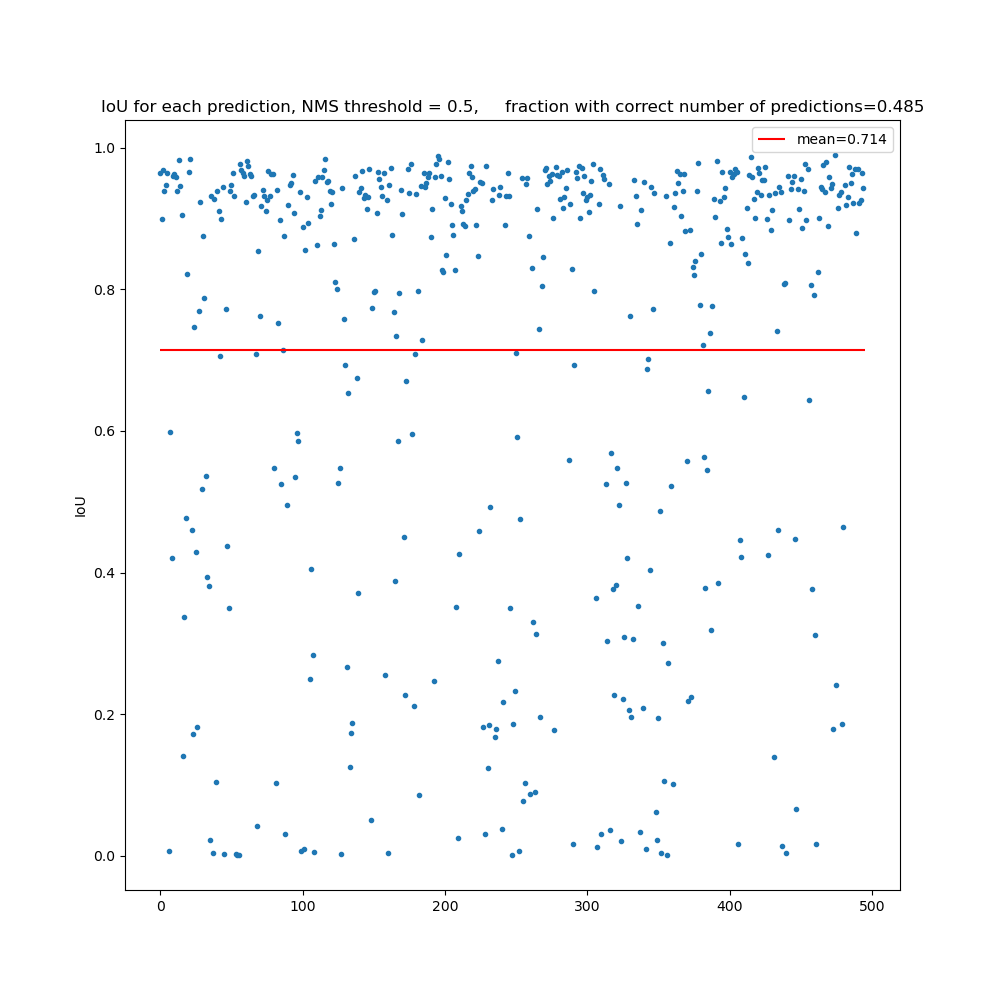

In [26]:
%matplotlib widget
plot_ious(iou_info, iou_thresholds)

#### Honestly surprised by this behavior. I was worried about cutting out too many events that do have overlapping boundary boxes, but increasing the threshold beyond .1 only led to worse performance both in terms of average IoU and number of images with correct number of predictions. Going to try exploring a threshold closer to .1.

In [20]:
iou_thresholds_2 = [.01, .05, .2]
iou_info_2 = [get_ious(it) for it in iou_thresholds_2]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


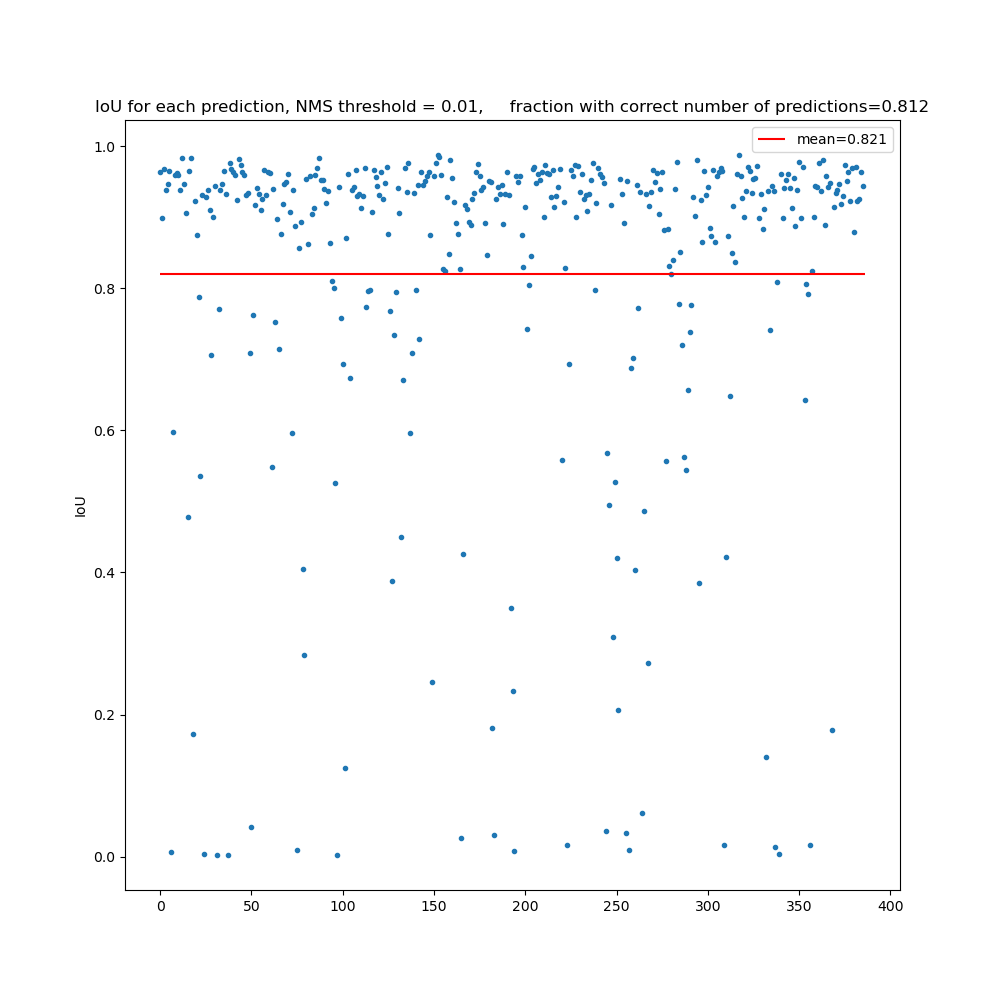

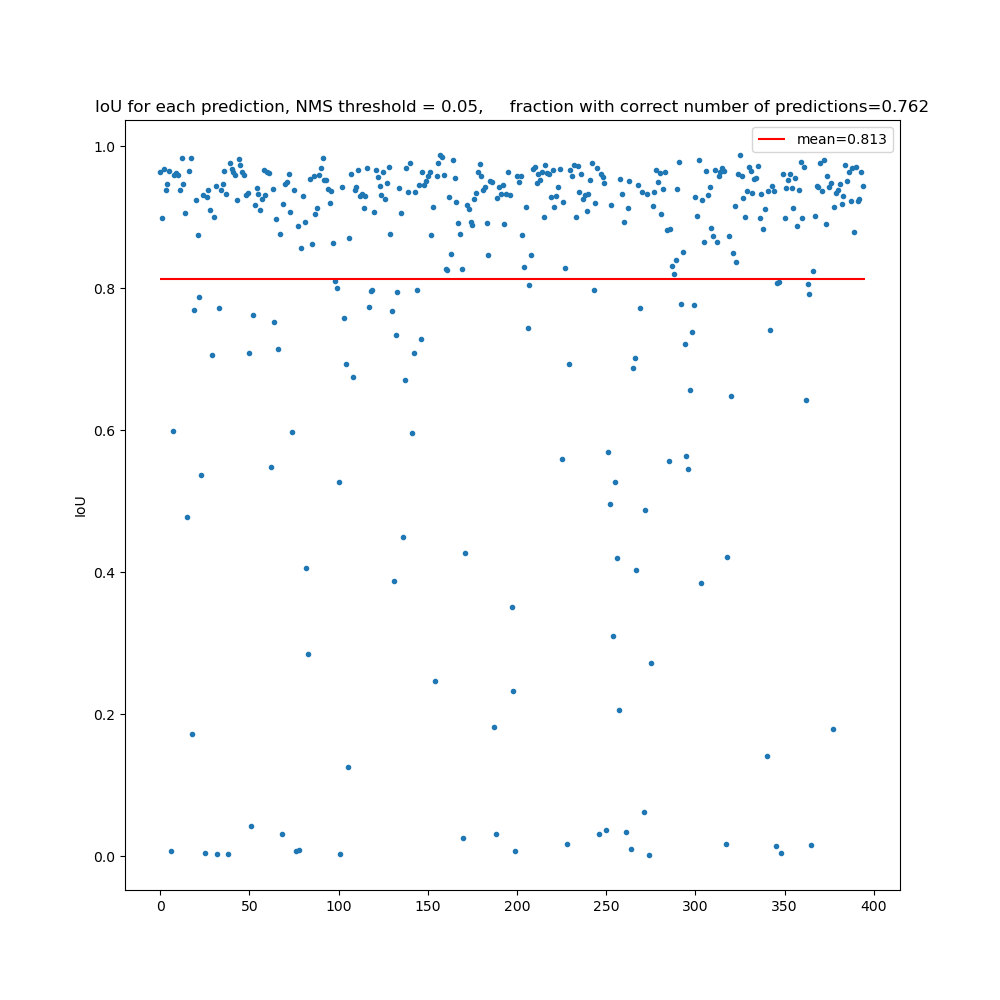

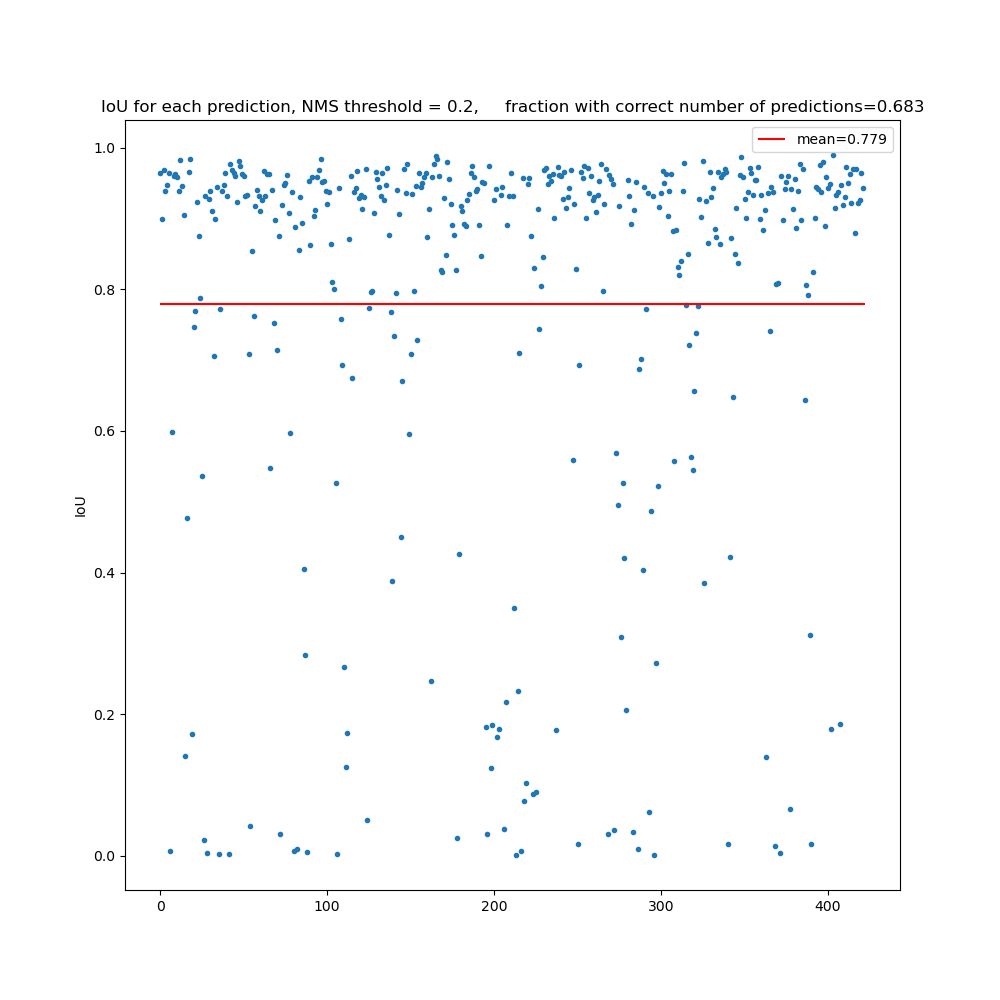

In [27]:
%matplotlib widget
plot_ious(iou_info_2, iou_thresholds_2)

#### I guess smaller is better, going to continue making the threshold smaller until I see diminishing returns.

In [22]:
iou_thresholds_3 = [.001, .002, .005]
iou_info_3 = [get_ious(it) for it in iou_thresholds_3]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


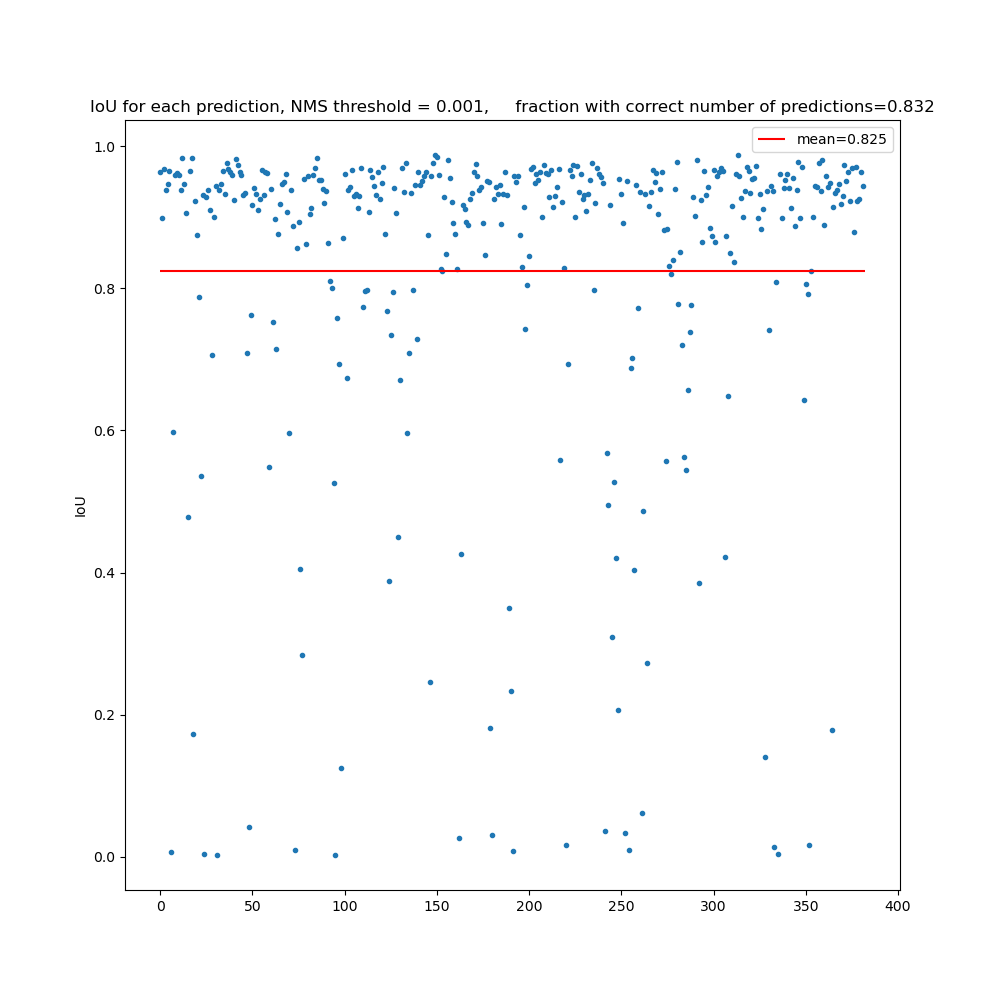

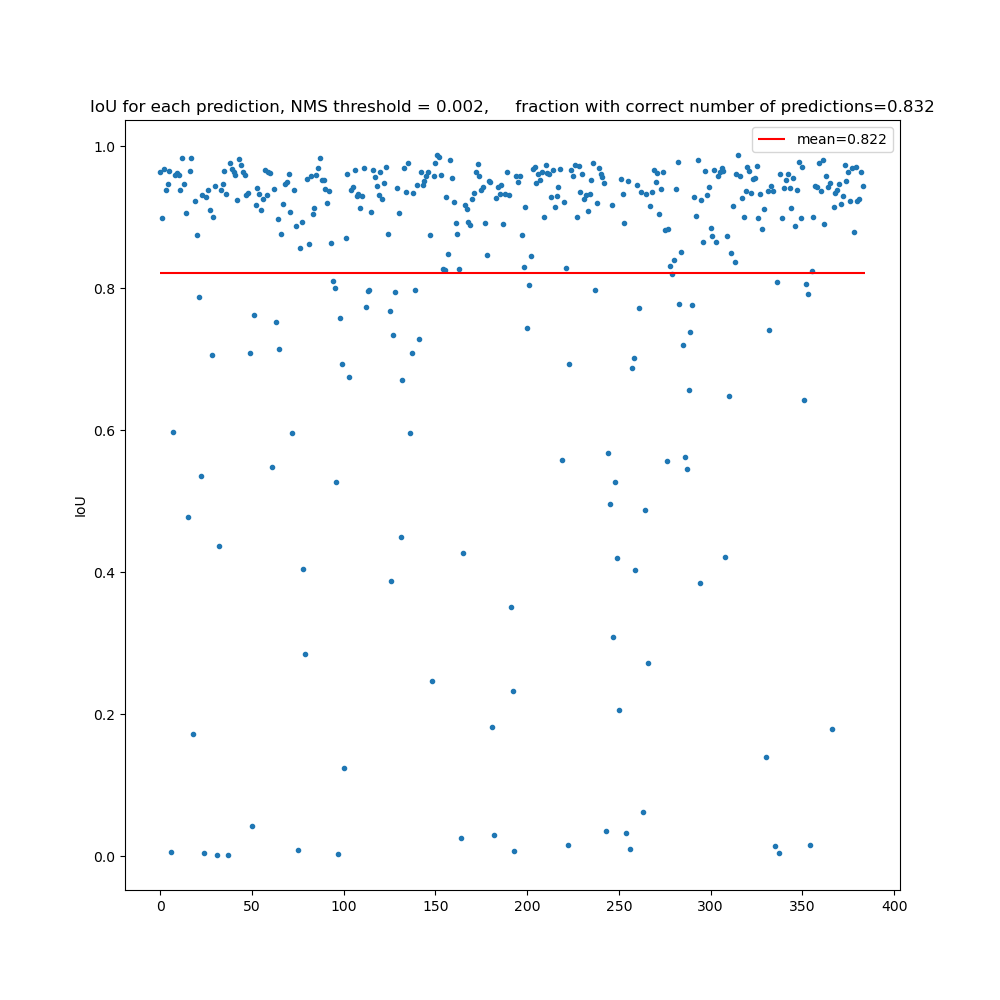

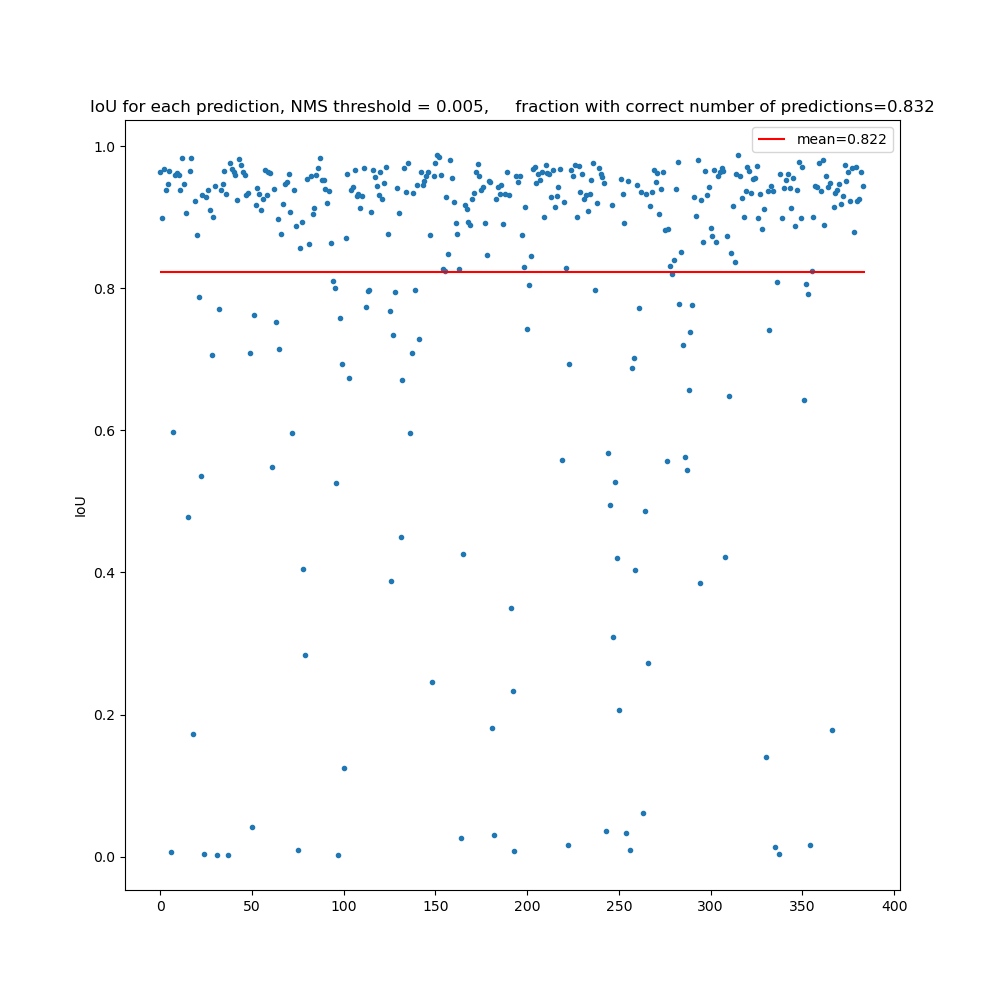

In [28]:
plot_ious(iou_info_3, iou_thresholds_3)

#### Hit the limit of improvement with reducing IoU threshold for the NMS somewhere between .05 and .1. Now realizing that it would have been informative to get the ratio of targets to predictions in each case rather than the binary num_boxes_target = num_boxes_predicted. Will fix this later, need a climbing break.